# SHAP Parkinson Prototype

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

/opt/homebrew/Caskroom/miniforge/base/envs/xai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [2]:
data = pd.read_csv("parkinsons.csv")
data.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

Matrix column entries (attributes):
- name - ASCII subject name and recording number
- MDVP:Fo(Hz) - Average vocal fundamental frequency
- MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
- MDVP:Flo(Hz) - Minimum vocal fundamental frequency
- MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several 
- measures of variation in fundamental frequency
- MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several    measures of variation in amplitude
- NHR,HNR - Two measures of ratio of noise to tonal components in the voice
- status - Health status of the subject (one) - Parkinson's, (zero) - healthy
- RPDE,D2 - Two nonlinear dynamical complexity measures
- DFA - Signal fractal scaling exponent
- spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation 

In [4]:
target = data['status']
target

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

In [5]:
features = data.drop(columns=['name','status'])
features.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, 
                                                    random_state=42)

In [7]:
model = RandomForestClassifier(n_estimators=200, max_depth=30)

In [8]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, n_estimators=200)

In [9]:
model.score(X_test, y_test)

0.9487179487179487

In [10]:
X_test.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,112.239,126.609,104.095,0.00472,0.00004,0.00238,0.00290,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-5.634576,0.306014,2.419253,0.209191
16,144.188,349.259,82.764,0.00544,0.00004,0.00211,0.00292,0.00632,0.02047,0.192,...,0.02074,0.02908,0.01859,22.333,0.567380,0.644692,-5.440040,0.239764,2.264501,0.218164
155,117.870,127.349,95.654,0.00647,0.00005,0.00356,0.00300,0.01067,0.03087,0.276,...,0.02402,0.04977,0.02631,22.431,0.628300,0.652025,-3.583722,0.207914,2.439597,0.206256
96,159.116,168.913,144.811,0.00342,0.00002,0.00178,0.00184,0.00535,0.03381,0.307,...,0.02809,0.05417,0.00852,22.663,0.366329,0.693429,-6.417440,0.194627,2.473239,0.151709
68,143.533,162.215,65.809,0.01101,0.00008,0.00647,0.00467,0.01941,0.05384,0.478,...,0.03392,0.09455,0.04882,20.338,0.513237,0.731444,-5.869750,0.151814,2.118496,0.185580


In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_values = shap_values[0]

In [12]:
shap_values.shape

(39, 22)

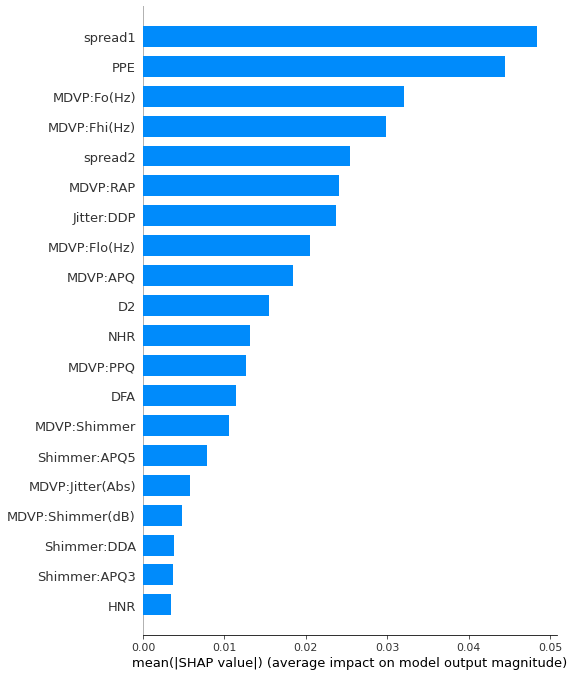

In [13]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

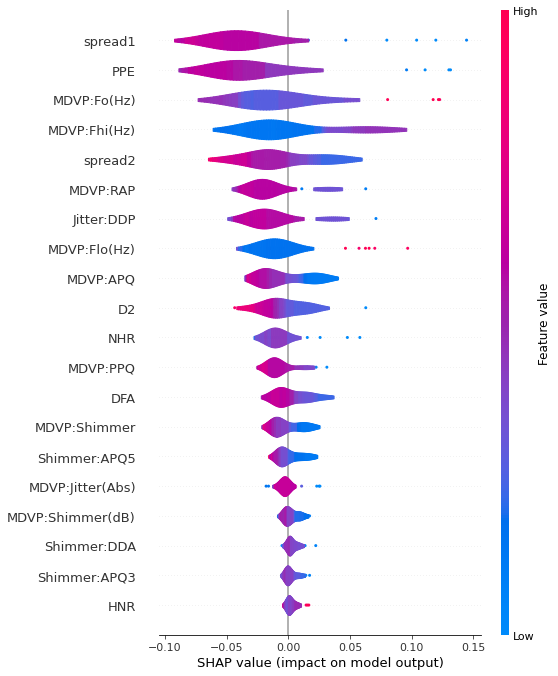

In [14]:
shap.summary_plot(shap_values, X_test, plot_type='violin',show=False)
plt.show()

In [15]:
model.feature_importances_

array([0.10807865, 0.08249334, 0.06275423, 0.02687101, 0.03019425,
       0.05072818, 0.03359919, 0.04888597, 0.02071152, 0.0202375 ,
       0.02748214, 0.0299946 , 0.04445934, 0.02041059, 0.03532289,
       0.02613782, 0.02365963, 0.02356944, 0.09666129, 0.04505086,
       0.03696281, 0.10573476])

<BarContainer object of 22 artists>

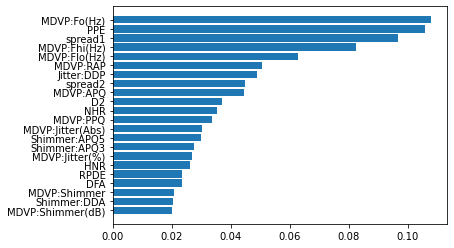

In [16]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(features.columns[sorted_idx], model.feature_importances_[sorted_idx])

In [17]:
features.columns

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP',
       'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')

In [18]:
#for elem in features.columns:
#    shap.dependence_plot(elem, shap_values, X_test, show=False)

In [19]:
X_test.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,112.239,126.609,104.095,0.00472,0.00004,0.00238,0.00290,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-5.634576,0.306014,2.419253,0.209191
16,144.188,349.259,82.764,0.00544,0.00004,0.00211,0.00292,0.00632,0.02047,0.192,...,0.02074,0.02908,0.01859,22.333,0.567380,0.644692,-5.440040,0.239764,2.264501,0.218164
155,117.870,127.349,95.654,0.00647,0.00005,0.00356,0.00300,0.01067,0.03087,0.276,...,0.02402,0.04977,0.02631,22.431,0.628300,0.652025,-3.583722,0.207914,2.439597,0.206256
96,159.116,168.913,144.811,0.00342,0.00002,0.00178,0.00184,0.00535,0.03381,0.307,...,0.02809,0.05417,0.00852,22.663,0.366329,0.693429,-6.417440,0.194627,2.473239,0.151709
68,143.533,162.215,65.809,0.01101,0.00008,0.00647,0.00467,0.01941,0.05384,0.478,...,0.03392,0.09455,0.04882,20.338,0.513237,0.731444,-5.869750,0.151814,2.118496,0.185580


In [20]:
X_test.shape

(39, 22)

In [21]:
X_test

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,112.239,126.609,104.095,0.00472,0.000040,0.00238,0.00290,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-5.634576,0.306014,2.419253,0.209191
16,144.188,349.259,82.764,0.00544,0.000040,0.00211,0.00292,0.00632,0.02047,0.192,...,0.02074,0.02908,0.01859,22.333,0.567380,0.644692,-5.440040,0.239764,2.264501,0.218164
155,117.870,127.349,95.654,0.00647,0.000050,0.00356,0.00300,0.01067,0.03087,0.276,...,0.02402,0.04977,0.02631,22.431,0.628300,0.652025,-3.583722,0.207914,2.439597,0.206256
96,159.116,168.913,144.811,0.00342,0.000020,0.00178,0.00184,0.00535,0.03381,0.307,...,0.02809,0.05417,0.00852,22.663,0.366329,0.693429,-6.417440,0.194627,2.473239,0.151709
68,143.533,162.215,65.809,0.01101,0.000080,0.00647,0.00467,0.01941,0.05384,0.478,...,0.03392,0.09455,0.04882,20.338,0.513237,0.731444,-5.869750,0.151814,2.118496,0.185580
153,121.345,139.644,98.250,0.00684,0.000060,0.00388,0.00332,0.01164,0.02534,0.241,...,0.02056,0.04019,0.04179,21.520,0.566867,0.670475,-4.865194,0.246404,2.013530,0.168581
55,109.860,126.358,104.437,0.00874,0.000080,0.00398,0.00539,0.01193,0.03209,0.307,...,0.02454,0.05368,0.01180,20.767,0.558586,0.811843,-4.333543,0.221727,2.014606,0.344834
15,142.167,217.455,83.159,0.00369,0.000030,0.00157,0.00203,0.00471,0.01503,0.126,...,0.01359,0.02316,0.00839,25.175,0.565924,0.658245,-5.340115,0.210185,2.205546,0.234589
112,204.664,221.300,189.621,0.00841,0.000040,0.00502,0.00485,0.01506,0.02378,0.210,...,0.01767,0.03831,0.01316,21.305,0.498877,0.722085,-4.876336,0.212054,2.376749,0.268144
111,208.519,220.315,199.020,0.00609,0.000030,0.00368,0.00339,0.01105,0.01761,0.155,...,0.01307,0.02855,0.00830,22.407,0.338097,0.712466,-6.471427,0.184378,2.502336,0.136390


In [22]:
y_test

138    1
16     1
155    1
96     1
68     1
153    1
55     1
15     1
112    1
111    1
184    0
18     1
82     1
9      1
164    1
117    1
69     1
113    1
192    0
119    1
123    1
144    1
66     1
45     0
158    1
115    1
67     1
93     1
30     0
101    1
118    1
75     1
24     1
172    0
127    1
169    0
19     1
168    0
73     1
Name: status, dtype: int64

In [23]:
X_test.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,112.239,126.609,104.095,0.00472,0.00004,0.00238,0.00290,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-5.634576,0.306014,2.419253,0.209191
16,144.188,349.259,82.764,0.00544,0.00004,0.00211,0.00292,0.00632,0.02047,0.192,...,0.02074,0.02908,0.01859,22.333,0.567380,0.644692,-5.440040,0.239764,2.264501,0.218164
155,117.870,127.349,95.654,0.00647,0.00005,0.00356,0.00300,0.01067,0.03087,0.276,...,0.02402,0.04977,0.02631,22.431,0.628300,0.652025,-3.583722,0.207914,2.439597,0.206256
96,159.116,168.913,144.811,0.00342,0.00002,0.00178,0.00184,0.00535,0.03381,0.307,...,0.02809,0.05417,0.00852,22.663,0.366329,0.693429,-6.417440,0.194627,2.473239,0.151709
68,143.533,162.215,65.809,0.01101,0.00008,0.00647,0.00467,0.01941,0.05384,0.478,...,0.03392,0.09455,0.04882,20.338,0.513237,0.731444,-5.869750,0.151814,2.118496,0.185580


In [24]:
X_test.loc[[138]]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,112.239,126.609,104.095,0.00472,0.00004,0.00238,0.0029,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-5.634576,0.306014,2.419253,0.209191


In [25]:
instance = X_test.loc[[138]]
shap_values = explainer.shap_values(instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], instance)

In [26]:
y_test.head()

138    1
16     1
155    1
96     1
68     1
Name: status, dtype: int64

In [27]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



In [28]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 5,  2],
       [ 0, 32]])

In [29]:
X_test

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,112.239,126.609,104.095,0.00472,0.000040,0.00238,0.00290,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-5.634576,0.306014,2.419253,0.209191
16,144.188,349.259,82.764,0.00544,0.000040,0.00211,0.00292,0.00632,0.02047,0.192,...,0.02074,0.02908,0.01859,22.333,0.567380,0.644692,-5.440040,0.239764,2.264501,0.218164
155,117.870,127.349,95.654,0.00647,0.000050,0.00356,0.00300,0.01067,0.03087,0.276,...,0.02402,0.04977,0.02631,22.431,0.628300,0.652025,-3.583722,0.207914,2.439597,0.206256
96,159.116,168.913,144.811,0.00342,0.000020,0.00178,0.00184,0.00535,0.03381,0.307,...,0.02809,0.05417,0.00852,22.663,0.366329,0.693429,-6.417440,0.194627,2.473239,0.151709
68,143.533,162.215,65.809,0.01101,0.000080,0.00647,0.00467,0.01941,0.05384,0.478,...,0.03392,0.09455,0.04882,20.338,0.513237,0.731444,-5.869750,0.151814,2.118496,0.185580
153,121.345,139.644,98.250,0.00684,0.000060,0.00388,0.00332,0.01164,0.02534,0.241,...,0.02056,0.04019,0.04179,21.520,0.566867,0.670475,-4.865194,0.246404,2.013530,0.168581
55,109.860,126.358,104.437,0.00874,0.000080,0.00398,0.00539,0.01193,0.03209,0.307,...,0.02454,0.05368,0.01180,20.767,0.558586,0.811843,-4.333543,0.221727,2.014606,0.344834
15,142.167,217.455,83.159,0.00369,0.000030,0.00157,0.00203,0.00471,0.01503,0.126,...,0.01359,0.02316,0.00839,25.175,0.565924,0.658245,-5.340115,0.210185,2.205546,0.234589
112,204.664,221.300,189.621,0.00841,0.000040,0.00502,0.00485,0.01506,0.02378,0.210,...,0.01767,0.03831,0.01316,21.305,0.498877,0.722085,-4.876336,0.212054,2.376749,0.268144
111,208.519,220.315,199.020,0.00609,0.000030,0.00368,0.00339,0.01105,0.01761,0.155,...,0.01307,0.02855,0.00830,22.407,0.338097,0.712466,-6.471427,0.184378,2.502336,0.136390


In [30]:
X_test.loc[[111]]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
111,208.519,220.315,199.02,0.00609,0.00003,0.00368,0.00339,0.01105,0.01761,0.155,...,0.01307,0.02855,0.0083,22.407,0.338097,0.712466,-6.471427,0.184378,2.502336,0.13639


In [31]:
X_test.loc[[112]]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
112,204.664,221.3,189.621,0.00841,0.00004,0.00502,0.00485,0.01506,0.02378,0.21,...,0.01767,0.03831,0.01316,21.305,0.498877,0.722085,-4.876336,0.212054,2.376749,0.268144


In [32]:
instance = X_test.loc[[111]]
shap_values = explainer.shap_values(instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], instance)

In [33]:
instance = X_test.loc[[112]]
shap_values = explainer.shap_values(instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], instance)

In [34]:
i111 = (X_test.loc[[112]]).to_csv("name1")

In [35]:
shap_values

[array([[ 0.02848939, -0.00343567,  0.07000715, -0.00311128, -0.00300594,
         -0.02463092, -0.01332755, -0.02200878, -0.00610984, -0.0011529 ,
          0.00073547, -0.00634485, -0.00688303,  0.0004863 , -0.01709041,
          0.0008941 ,  0.00229219, -0.00695585, -0.04312957, -0.02229417,
         -0.00515276, -0.04631596]]),
 array([[-0.02848939,  0.00343567, -0.07000715,  0.00311128,  0.00300594,
          0.02463092,  0.01332755,  0.02200878,  0.00610984,  0.0011529 ,
         -0.00073547,  0.00634485,  0.00688303, -0.0004863 ,  0.01709041,
         -0.0008941 , -0.00229219,  0.00695585,  0.04312957,  0.02229417,
          0.00515276,  0.04631596]])]

In [36]:
X_test.loc[[138]]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,112.239,126.609,104.095,0.00472,0.00004,0.00238,0.0029,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-5.634576,0.306014,2.419253,0.209191


In [37]:
i111 = (X_test.loc[[138]]).to_csv("name2.csv")

In [38]:
X_test.loc[138, ['MDVP:Fo(Hz)','MDVP:Fhi(Hz)','MDVP:Flo(Hz)','PPE','spread1']] = [122.239000, 136.609000,
                                                                 114.009500, 0.4, -6.6]

In [39]:
X_test.loc[[138]]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,122.239,136.609,114.0095,0.00472,0.00004,0.00238,0.0029,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-6.6,0.306014,2.419253,0.4


In [40]:
instance = X_test.loc[[138]]
shap_values = explainer.shap_values(instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], instance)

In [41]:
#X_test.loc[138, ['MDVP:Fo(Hz)','MDVP:Fhi(Hz)','MDVP:Flo(Hz)']] = [1122.239000, 1136.609000,
  #                                                               11114.009500]

In [42]:
X_test.loc[[138]]

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
138,122.239,136.609,114.0095,0.00472,0.00004,0.00238,0.0029,0.00715,0.05643,0.517,...,0.04451,0.09211,0.02629,17.366,0.640945,0.701404,-6.6,0.306014,2.419253,0.4


In [43]:
instance = X_test.loc[[138]]
shap_values = explainer.shap_values(instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], instance)

In [44]:
import eli5
from eli5.sklearn import PermutationImportance

In [45]:
perm = PermutationImportance(model).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.0359 ± 0.0410,PPE
0.0256 ± 0.0324,spread1
0.0205 ± 0.0384,MDVP:Fhi(Hz)
0.0154 ± 0.0251,spread2
0.0103 ± 0.0251,MDVP:RAP
0.0051 ± 0.0205,DFA
0 ± 0.0000,RPDE
0 ± 0.0000,HNR
0 ± 0.0000,NHR
0 ± 0.0000,Shimmer:DDA
